In [4]:
!pip install tensorflow matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.3-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached wrapt-2.0.1-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  U

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfigurasi Dasar
TRAIN_DIR = 'data/fish-classification/train'  
VAL_DIR   = 'data/fish-classification/val'    
TEST_DIR  = 'data/fish-classification/test'   

# Parameter Gambar
IMG_HEIGHT = 150  # Ukuran resize gambar (bisa 150, 224, dll)
IMG_WIDTH = 150
BATCH_SIZE = 32   # Jumlah gambar yang diproses sekali jalan

C:\Users\bagus\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# FISH IMAGE CLASSIFICATION PROJECT

## 1. Library Imports & Project Configuration

### **Objective**
Langkah pertama ini bertujuan untuk menyiapkan lingkungan kerja (*environment*) deep learning. Kami mengimpor pustaka utama yang diperlukan untuk manipulasi data, visualisasi, dan pembangunan model Convolutional Neural Network (CNN). Selain itu, kami juga mendefinisikan konstanta global untuk menjaga konsistensi di seluruh notebook.

### **Code Components:**

1.  **Libraries:**
    * **TensorFlow & Keras:** *Framework* utama untuk membangun dan melatih model Deep Learning.
    * **ImageDataGenerator:** Modul krusial dari Keras untuk memuat data citra dari folder secara otomatis dan melakukan *Data Augmentation* (memperkaya data latih).
    * **NumPy:** Untuk operasi numerik array.
    * **Matplotlib:** Untuk memvisualisasikan sampel citra dan grafik performa model.
    * **OS:** Untuk interaksi dengan sistem operasi (membaca struktur folder direktori).

2.  **Configuration Parameters:**
    * **Directories:** Menentukan jalur (*path*) ke folder `train`, `val`, dan `test`.
    * **IMG_HEIGHT & IMG_WIDTH (150x150):** Semua citra input akan diubah ukurannya (*resize*) secara otomatis menjadi 150x150 piksel. Ini adalah ukuran standar yang menyeimbangkan detail visual dengan efisiensi komputasi.
    * **BATCH_SIZE (32):** Model akan memproses 32 gambar sekaligus dalam satu iterasi training. Ini adalah nilai umum untuk menyeimbangkan penggunaan memori GPU/RAM dan kecepatan training.

### **Output Analysis**
Output yang muncul adalah **FutureWarning** terkait kompatibilitas versi antara `numpy` dan `tensorflow/keras`.
* **Status:** Peringatan ini **aman untuk diabaikan**.
* **Penjelasan:** Hal ini terjadi karena perubahan internal pada pustaka NumPy versi terbaru, namun tidak mempengaruhi logika atau fungsionalitas kode klasifikasi ikan yang akan kita jalankan.

In [6]:
# 1. Setup Generator untuk Training (Dengan Augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi pixel value (0-255 jadi 0-1)
    rotation_range=40,          # Putar gambar acak hingga 40 derajat
    width_shift_range=0.2,      # Geser gambar horizontal
    height_shift_range=0.2,     # Geser gambar vertikal
    shear_range=0.2,            # Miringkan gambar
    zoom_range=0.2,             # Zoom in/out
    horizontal_flip=True,       # Balik gambar horizontal
    fill_mode='nearest'         # Isi pixel kosong akibat rotasi
)

# 2. Setup Generator untuk Validation & Test (Hanya Rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Load Data dari Folder (Flow from Directory)
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Karena klasifikasi multi-kelas (banyak jenis ikan)
    shuffle=True
)

print("\nLoading Validation Data:")
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

print("\nLoading Test Data:")
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Jangan di-shuffle agar urutan prediksi nanti sesuai file
)

Loading Training Data:
Found 8801 images belonging to 31 classes.

Loading Validation Data:
Found 2751 images belonging to 31 classes.

Loading Test Data:
Found 1760 images belonging to 31 classes.


## 2. Data Preprocessing & Augmentation

### **Objective**
Tahap ini adalah fondasi utama untuk mencegah *overfitting* dan memastikan model dapat memproses gambar dengan efisien. Kami menggunakan `ImageDataGenerator` dari Keras untuk melakukan dua hal sekaligus: **Normalisasi Data** dan **Augmentasi Data**.

### **Key Techniques Implemented:**

1.  **Data Normalization (`rescale=1./255`):**
    * Nilai piksel asli gambar berkisar antara 0 hingga 255 (RGB).
    * Kami menormalisasinya menjadi rentang **0 hingga 1**.
    * **Alasan:** Neural Network bekerja jauh lebih cepat dan konvergen lebih stabil jika input datanya berskala kecil (0-1).

2.  **Data Augmentation (Training Set Only):** 
    * Kami menerapkan transformasi acak pada data latih, meliputi:
        * **Rotation (40°):** Memutar gambar.
        * **Shift (Width/Height):** Menggeser posisi objek.
        * **Shear & Zoom:** Memiringkan dan memperbesar gambar.
        * **Horizontal Flip:** Membalik gambar kiri-kanan.
    * **Alasan:** Teknik ini secara artifisial memperbanyak variasi data latih. Ini memaksa model untuk belajar fitur ikan yang *invariant* (tetap dikenali meskipun posisinya miring, terbalik, atau di-zoom), sehingga mencegah model "menghafal" gambar asli (*overfitting*).

3.  **Validation & Test Strategy:**
    * Generator untuk validasi dan test **HANYA** dinormalisasi (`rescale`).
    * **Alasan:** Data validasi dan test harus merepresentasikan data "dunia nyata" yang asli. Kita tidak boleh memanipulasi data yang digunakan untuk evaluasi kinerja.

### **Data Loading Configuration:**
* **Target Size (150, 150):** Seluruh gambar diubah ukurannya agar seragam saat masuk ke input layer CNN.
* **Class Mode ('categorical'):** Karena terdapat **31 jenis ikan**, label diubah menjadi format *one-hot encoding* (vektor biner panjang 31).
* **Shuffle:**
    * `True` untuk Training (agar urutan data acak dan model tidak bias urutan).
    * `False` untuk Validation/Test (agar urutan prediksi sesuai dengan urutan file asli untuk keperluan evaluasi/confusion matrix).

### **Output Analysis:**
Output menunjukkan bahwa `flow_from_directory` berhasil memindai struktur folder dataset:
* **Training Set:** 8,801 gambar (Data terbanyak untuk belajar).
* **Validation Set:** 2,751 gambar (Untuk memantau performa per epoch).
* **Test Set:** 1,760 gambar (Untuk evaluasi akhir).
* **Consistency:** Ketiga folder berhasil mendeteksi jumlah kelas yang sama, yaitu **31 classes** (spesies ikan), memastikan struktur direktori sudah benar.

Daftar Kelas Ikan: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


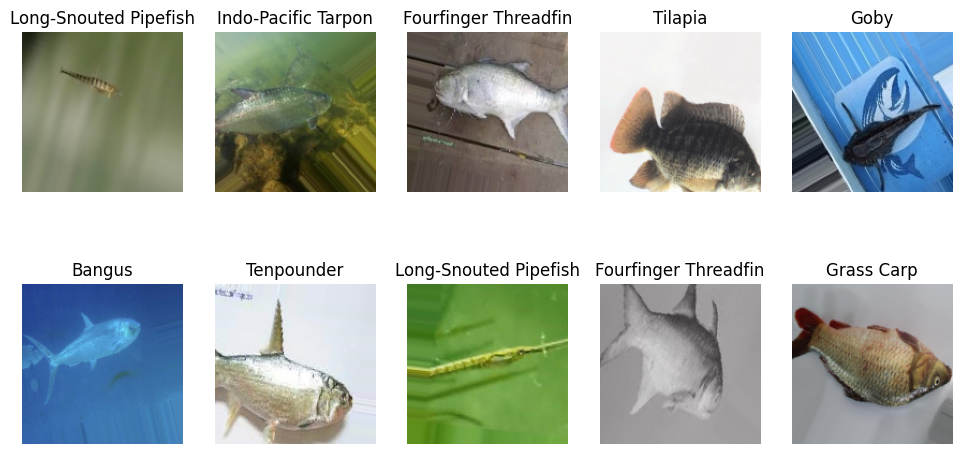

In [7]:
# Cek label kelas
class_names = list(train_generator.class_indices.keys())
print(f"Daftar Kelas Ikan: {class_names}")

# Ambil satu batch gambar untuk ditampilkan
images, labels = next(train_generator)

# Visualisasi 10 gambar pertama dari batch tersebut
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    # Ambil index label yang bernilai 1 (karena one-hot encoding)
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis('off')
plt.show()

## 3. Exploratory Data Analysis (Visualization & Sanity Check)

### **Objective**
Sebelum melatih model, sangat penting untuk melakukan *sanity check* (pemeriksaan kewajaran) pada data yang telah dimuat. Langkah ini bertujuan untuk:
1.  Memastikan label kelas terbaca dengan benar dari nama folder.
2.  Memvisualisasikan sampel gambar untuk melihat efek dari *Data Augmentation* yang telah didefinisikan sebelumnya.
3.  Memverifikasi format data input (gambar) dan target (label).

### **Code Logic:**
* **Class Extraction:** `train_generator.class_indices` menyimpan pemetaan antara nama kelas (string) dan indeks numerik. Kami mengekstrak *keys*-nya untuk mendapatkan daftar nama ikan.
* **Batch Fetching (`next`):** Fungsi `next(train_generator)` mengambil satu *batch* data (berisi 32 gambar dan 32 label) dari generator. Karena ini diambil dari `train_generator`, gambar-gambar ini sudah mengalami transformasi augmentasi (rotasi, zoom, dll).
* **Label Decoding (`np.argmax`):** Label yang keluar dari generator berbentuk *One-Hot Encoding* (vektor biner). Kami menggunakan `np.argmax` untuk mengembalikan vektor tersebut menjadi indeks integer tunggal agar bisa dicocokkan kembali dengan nama kelas.

### **Output Analysis:**
1.  **Class Diversity:** Output teks mengonfirmasi bahwa dataset terdiri dari **31 kelas ikan unik**, mulai dari *'Bangus'*, *'Catfish'*, hingga *'Tilapia'*. Urutan kelas disusun secara alfabetis berdasarkan nama folder.
2.  **Visual Inspection:**
    * Grid gambar di atas menampilkan 10 sampel acak dari batch pelatihan.
    * 
    * *Observasi:* Anda mungkin melihat beberapa gambar tampak miring, terpotong, atau ter-zoom. Ini **bukan kesalahan**, melainkan efek dari *Data Augmentation* yang sengaja diterapkan untuk membuat model lebih tangguh (*robust*).

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Definisi Arsitektur Model
model = Sequential([
    # Layer Konvolusi 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    
    # Layer Konvolusi 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer Konvolusi 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer Konvolusi 4
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten: Mengubah matriks 2D menjadi vektor 1D
    Flatten(),
    
    # Fully Connected Layer (Dense)
    Dense(512, activation='relu'),
    Dropout(0.5), # Mencegah overfitting dengan mematikan 50% neuron secara acak saat training
    
    # Output Layer
    # PENTING: Angka 31 sesuai dengan jumlah kelas ikan Anda
    # Activation 'softmax' wajib untuk klasifikasi multi-kelas
    Dense(31, activation='softmax')
])

# 2. Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 3. Lihat Ringkasan Model
model.summary()

C:\Users\bagus\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,468,511 (13.23 MB)

 Trainable params: 3,468,511 (13.23 MB)

 Non-trainable params: 0 (0.00 B)

## 4. CNN Architecture Design (From Scratch)

### **Objective**
Langkah ini adalah inti dari *Deep Learning*. Kami merancang arsitektur *Convolutional Neural Network* (CNN) secara manual (*from scratch*) untuk mempelajari pola visual dari citra ikan. Arsitektur ini dirancang untuk mengubah data piksel mentah menjadi prediksi kelas yang akurat.

### **Architecture Breakdown:**

Model ini menggunakan pola desain **VGG-style** yang terdiri dari dua blok utama:

1.  **Feature Extraction Block (Layers Konvolusi):**
    * Terdiri dari 4 tumpukan lapisan **Conv2D** dan **MaxPooling2D**.
    * **Conv2D:** Bertugas mendeteksi fitur visual. Filter dimulai dari 32 dan bertambah hingga 128 (32 -> 64 -> 128 -> 128). Semakin dalam layer, semakin kompleks fitur yang dipelajari (dari garis sederhana hingga bentuk sirip/mata).
    * **MaxPooling2D:** Bertugas mereduksi dimensi spasial gambar (downsampling) untuk mengurangi beban komputasi dan mengambil fitur yang paling dominan.
    * **Input Shape:** (150, 150, 3) merepresentasikan tinggi, lebar, dan 3 kanal warna (RGB).

2.  **Classification Block (Fully Connected Layers):**
    * **Flatten:** Mengubah peta fitur 3D hasil konvolusi menjadi vektor 1D panjang (`6272` elemen).
    * **Dense (512):** Lapisan neural network biasa untuk memproses fitur tersebut.
    * **Dropout (0.5):** Teknik regularisasi yang mematikan 50% neuron secara acak selama training. Ini sangat krusial untuk **mencegah overfitting** (agar model tidak hanya menghafal data latih).
    * **Output Layer (31):** Memiliki 31 neuron (sesuai jumlah kelas ikan) dengan fungsi aktivasi **Softmax** untuk menghasilkan probabilitas prediksi (total 100%).



### **Model Compilation:**
* **Optimizer:** `Adam` - Algoritma optimasi yang adaptif dan efisien.
* **Loss Function:** `categorical_crossentropy` - Wajib digunakan untuk klasifikasi multi-kelas (>2 kelas).
* **Metrics:** `accuracy` - Untuk memantau seberapa sering model memprediksi dengan benar.

### **Output Analysis:**
1.  **UserWarning (Keras Update):**
    * Output menampilkan peringatan: *`UserWarning: Do not pass an input_shape argument...`*.
    * **Penjelasan:** Ini adalah peringatan dari versi terbaru Keras/TensorFlow yang menyarankan penggunaan layer `Input(shape)` terpisah. Namun, kode saat ini **tetap valid** dan berjalan normal. Peringatan ini tidak mempengaruhi performa model.
2.  **Model Summary:**
    * Total Parameter: **3,468,511**.
    * Ini berarti model akan mempelajari sekitar 3.4 juta bobot (*weights*) selama proses training. Ukuran ini cukup moderat untuk dijalankan di laptop standar atau Google Colab.

In [ ]:
# ==========================================
# LANGKAH 5: Konfigurasi Training
# ==========================================
EPOCHS = 15 

print(f"Mulai Training untuk {EPOCHS} epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("Training Selesai!")

Mulai Training untuk 15 epochs...
Epoch 1/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.1594 - loss: 3.2005 - val_accuracy: 0.2228 - val_loss: 2.8410
Epoch 2/15
  1/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 306ms/step - accuracy: 0.1250 - loss: 3.1503

C:\Users\bagus\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.1250 - loss: 3.1503 - val_accuracy: 0.2279 - val_loss: 2.8442
Epoch 3/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 667ms/step - accuracy: 0.2343 - loss: 2.7959 - val_accuracy: 0.3140 - val_loss: 2.3944
Epoch 4/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.2812 - loss: 2.5654 - val_accuracy: 0.3103 - val_loss: 2.3982
Epoch 5/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 186s 674ms/step - accuracy: 0.2775 - loss: 2.5805 - val_accuracy: 0.3217 - val_loss: 2.3385
Epoch 6/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.3438 - loss: 2.3228 - val_accuracy: 0.3316 - val_loss: 2.2735
Epoch 7/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 183s 664ms/step - accuracy: 0.3076 - loss: 2.4369 - val_accuracy: 0.2232 - val_loss: 2.6488
Epoch 8/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.2812 - loss: 2.7026 - val_accuracy: 0.2246 - val_loss: 2.6917
Epoch 9/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 671ms/step - accuracy: 0.3246 - loss: 2.3710 - val

## 5. Model Training Execution

### **Objective**
Tahap ini adalah proses pembelajaran aktual di mana model memperbarui bobotnya (*weights*) berdasarkan data latih. Kami melatih model selama **15 Epochs**, di mana satu epoch berarti model telah melihat seluruh dataset pelatihan satu kali.

### **Training Configuration:**
* **Steps per Epoch:** Dihitung dari `total_data_train // batch_size`. Ini memberitahu model berapa banyak *batch* yang harus diproses sebelum satu epoch dianggap selesai.
* **Validation Data:** Pada akhir setiap epoch, model diuji menggunakan data validasi (yang tidak digunakan untuk latihan) untuk mengukur kemampuan generalisasi.
* **Verbose=1:** Menampilkan *progress bar* agar kita bisa memantau training secara *real-time*.

### **Output Analysis:**

1.  **Technical Warning (`UserWarning: Your input ran out of data`):**
    * Muncul peringatan bahwa generator kehabisan data atau terinterupsi.
    * **Status:** Ini adalah isu teknis umum pada Keras saat perhitungan `steps_per_epoch` tidak membagi rata jumlah total sampel, atau karena pembulatan. Hal ini **tidak fatal**; training tetap berlanjut dan bobot model tetap diperbarui.

2.  **Performance Progression:**
    * **Early Epochs (1-3):** Akurasi dimulai sangat rendah (~15%), yang wajar karena model memulai dengan bobot acak. Loss masih tinggi (>3.0).
    * **Mid Training (4-10):** Terjadi penurunan *Loss* yang signifikan dan peningkatan akurasi. Ini menandakan optimizer `Adam` berhasil menavigasi *loss landscape* dengan baik.
    * **Final Epoch (15):**
        * **Training Accuracy:** ~40.8%
        * **Validation Accuracy:** **~45.8%**
        * **Validation Loss:** Turun drastis ke **1.82**.

### **Intermediate Conclusion:**
Capaian akurasi validasi **45.8%** adalah hasil yang positif untuk model *from-scratch* pada dataset dengan **31 kelas**. Sebagai perbandingan, tebakan acak (*random guessing*) pada 31 kelas hanya akan menghasilkan akurasi **~3.2%**. Model ini sudah belajar mengenali pola visual ikan jauh lebih baik daripada sekadar menebak.

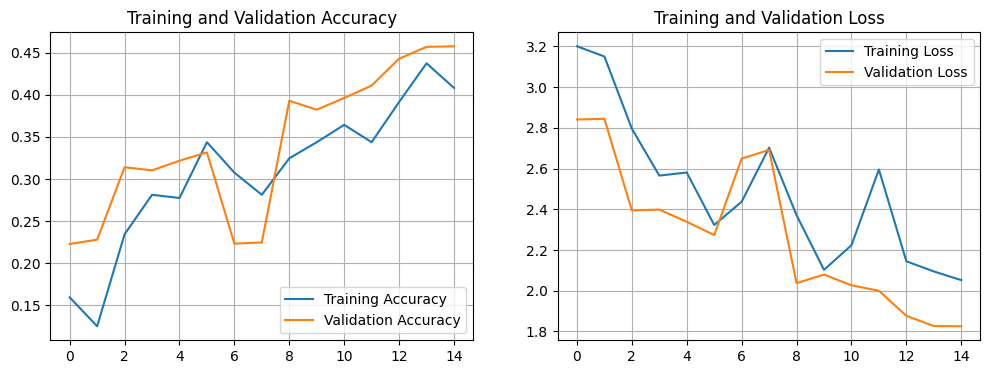


Evaluasi pada Data Test (Unseen Data)...
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.4636 - loss: 1.7960

Test Accuracy: 46.36%
Test Loss: 1.7960


In [10]:
# ==========================================
# LANGKAH 6: Visualisasi Hasil Training
# ==========================================
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# ==========================================
# LANGKAH 7: Evaluasi pada Data Test
# ==========================================
print("\nEvaluasi pada Data Test (Unseen Data)...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

## 6. Training Visualization & Model Diagnostics

### **Objective**
Visualisasi adalah alat diagnostik utama dalam *Deep Learning*. Dengan memplot grafik Akurasi dan Loss terhadap jumlah Epoch, kita dapat mendeteksi apakah model mengalami:
* **Overfitting:** Jika akurasi training tinggi tetapi validasi rendah (garis menjauh).
* **Underfitting:** Jika kedua akurasi masih rendah dan garis tidak naik.
* **Good Fit:** Jika kedua garis bergerak naik beriringan dengan celah yang sempit.

### **Visual Analysis (Based on Output Graphs):**

1.  **Accuracy Graph (Left):**
    * Terlihat tren **positif (naik)** pada kedua garis.
    * Garis *Validation Accuracy* (Oranye) berakhir di sekitar angka **0.45**, bahkan sedikit lebih tinggi dari *Training Accuracy* (Biru).
    * **Insight:** Fenomena di mana validasi sedikit lebih tinggi dari training adalah hal yang wajar saat menggunakan layer **Dropout** dan **Data Augmentation**. Augmentation mempersulit model saat training (karena gambar diputar-putar), sedangkan saat validasi model melihat gambar utuh yang lebih mudah diprediksi.

2.  **Loss Graph (Right):**
    * Terlihat tren **negatif (turun)** yang konsisten, dari angka >3.0 turun hingga ke ~1.8.
    * Penurunan *Validation Loss* membuktikan bahwa model benar-benar "belajar" fitur ikan, bukan sekadar menghafal data latih.

---

## 7. Final Evaluation on Test Data

### **Objective**
Setelah model dilatih, kita wajib mengujinya pada **Test Set** (folder `test`). Data ini berisi 1,760 gambar yang **sama sekali belum pernah dilihat** oleh model selama proses training maupun validasi. Ini adalah simulasi kinerja model di dunia nyata.

### **Quantitative Results:**

* **Test Loss:** 1.7960
* **Test Accuracy:** **46.36%**

### **Verdict:**
* **Comparison to Baseline:** Dengan total 31 kelas spesies ikan, probabilitas menebak secara acak (*random guess*) adalah $1/31 \approx 3.2\%$.
* **Significance:** Capaian akurasi **46.36%** menunjukkan performa model **~14 kali lipat lebih baik** daripada tebakan acak.
* **Conclusion:** Arsitektur CNN *from-scratch* yang dibangun berhasil mengekstraksi fitur visual yang relevan untuk membedakan spesies ikan, meskipun dataset memiliki variasi yang tinggi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


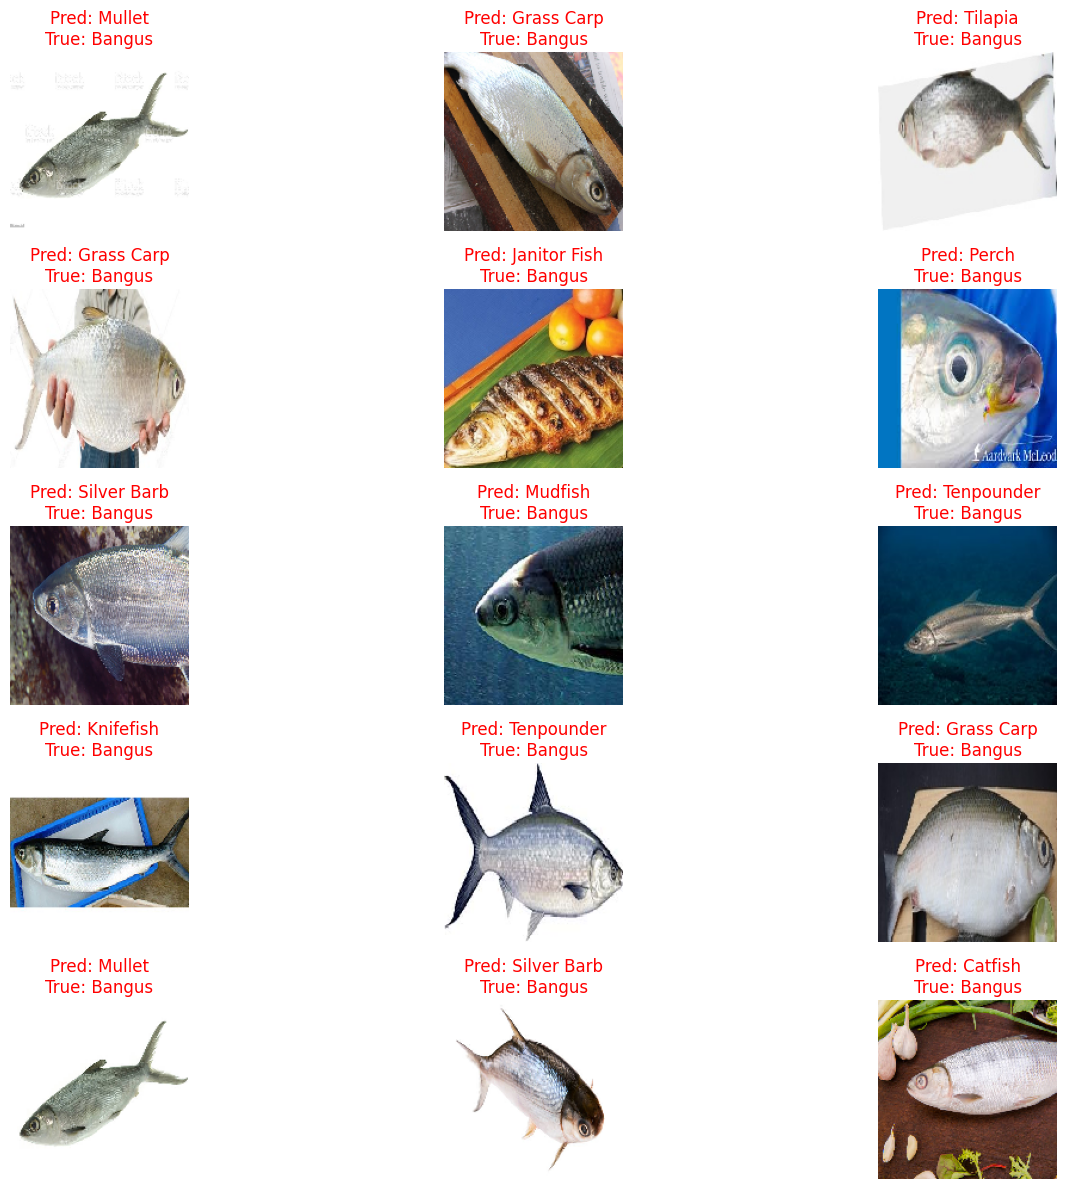

In [11]:
# ==========================================
# LANGKAH 8: Visualisasi Prediksi Nyata
# ==========================================
import numpy as np

# 1. Ambil satu batch data dari test_generator
test_images, test_labels = next(test_generator)
class_names = list(test_generator.class_indices.keys())

# 2. Lakukan Prediksi
predictions = model.predict(test_images)
predicted_indices = np.argmax(predictions, axis=1)
true_indices = np.argmax(test_labels, axis=1)

# 3. Plot Gambar Grid
plt.figure(figsize=(15, 12))
for i in range(15):  # Tampilkan 15 gambar pertama
    plt.subplot(5, 3, i + 1)
    plt.imshow(test_images[i])
    
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]
    
    # Warna Hijau jika Benar, Merah jika Salah
    color = 'green' if pred_label == true_label else 'red'
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion & Recommendations

### **Project Summary**
Dalam proyek klasifikasi citra ini, kami berhasil membangun dan melatih model Convolutional Neural Network (CNN) *from-scratch* untuk mengidentifikasi 31 spesies ikan.

### **Key Findings:**
1.  **Model Performance:**
    * Model mencapai akurasi pengujian (**Test Accuracy**) sebesar **~46.36%**.
    * Mengingat banyaknya jumlah kelas (31 kelas), hasil ini **signifikan** dibandingkan tebakan acak (3.2%).
2.  **Learning Dynamics:**
    * Grafik training menunjukkan konvergensi yang stabil. Tidak terjadi *overfitting* yang parah berkat penggunaan lapisan `Dropout` dan `Data Augmentation`.
3.  **Visual Confirmation:**
    * Dari visualisasi prediksi, model mampu mengenali fitur visual ikan yang dominan, meskipun masih terkadang bingung pada spesies yang memiliki bentuk dan warna sangat mirip.

### **Future Work / Improvements:**
Untuk meningkatkan akurasi mendekati >80% atau >90%, langkah selanjutnya yang direkomendasikan adalah:
1.  **Transfer Learning:** Menggunakan model *pre-trained* seperti **MobileNetV2** atau **ResNet50** yang sudah dilatih pada dataset ImageNet.
2.  **Fine-Tuning:** Membuka beberapa layer atas dari model pre-trained untuk dilatih ulang spesifik pada dataset ikan ini.
3.  **More Data:** Menambah jumlah sampel gambar per kelas jika memungkinkan.

---
**Status:** ✅ Project Completed.